In [1]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import numpy as np
import vedo

Error: Lumpy and/or the Lumerical API were not found.


Let's compare the primitive cell version of the diamond lattice of spheres with the cubic supercell version. The structure is point group 227, which has a rhombohedral primitive cell and an FCC conventional cell. 

The MPB documentation has a tutorial for the rhombohedral version, which we will start by including below:

In [44]:
import math
import meep as mp
from meep import mpb

# Dielectric spheres in a diamond (fcc) lattice.  This file is used in
# the "Data Analysis Tutorial" section of the MPB manual.

sqrt_half = math.sqrt(0.5)
geometry_lattice = mp.Lattice(
    basis_size=mp.Vector3(sqrt_half, sqrt_half, sqrt_half),
    basis1=mp.Vector3(0, 1, 1),
    basis2=mp.Vector3(1, 0, 1),
    basis3=mp.Vector3(1, 1)
)

# Corners of the irreducible Brillouin zone for the fcc lattice,
# in a canonical order:
vlist = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0, 0.625, 0.375),    # U
    mp.Vector3(0, 0.5, 0),          # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]

k_points = mp.interpolate(4, vlist)

# define a couple of parameters (which we can set from the command_line)
eps = 11.56  # the dielectric constant of the spheres
r = 0.25  # the radius of the spheres

diel = mp.Medium(epsilon=eps)

# A diamond lattice has two "atoms" per unit cell:
geometry = [mp.Sphere(r, center=mp.Vector3(0.125, 0.125, 0.125), material=diel),
            mp.Sphere(r, center=mp.Vector3(-0.125, -0.125, -0.125), material=diel)]

# A simple fcc lattice would have only one sphere/object at the origin.

resolution = 16  # use a 16x16x16 grid
mesh_size = 2
num_bands = 10

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    geometry=geometry,
    resolution=resolution,
    num_bands=num_bands,
    mesh_size=mesh_size
)

ms.run()

Initializing eigensolver data
Computing 10 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 2.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
     sphere, center = (0.125,0.125,0.125)
          radius 0.25
     sphere, center = (-0.125,-0.125,-0.125)
          radius 0.25
Geometric object tree has depth 4 and 35 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
31 k-points
  Vector3<0.0, 0.5, 0.5>
  Vector3<0.0, 0.525, 0.475>
  Vector3<0.0, 0.55, 0.45>
  Vector3<0.0, 0.575, 0.425>
  Vector3<0.0, 0.6, 0.4>
  Vector3<0.0, 0.625, 0.375>
  Vector3<0.0, 0.6, 0.3>
  Vector3<0.0, 0.575, 0.225>
  Vector3<0.0, 0.55, 0.15000000000000002>


And we'll plot the results:


epsilon: 1-11.56, mean 6.21953, harm. mean 2.01398, 61.3426% > 1, 49.4274% "fill"
real part range: 1 .. 11.56


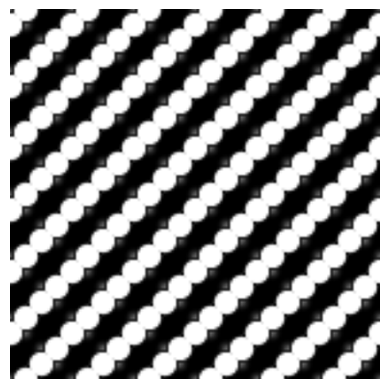

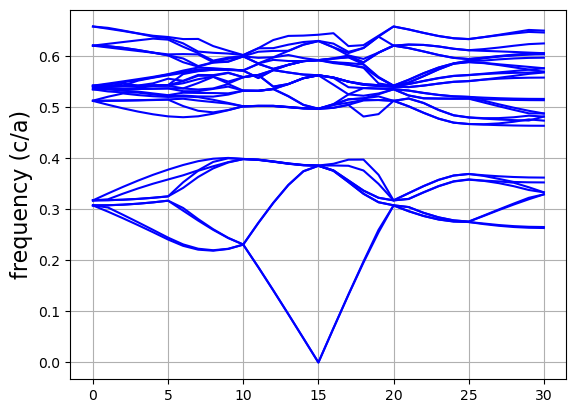

In [48]:
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=True, periods=6, resolution=64)
eps = ms.get_epsilon()
rhomb_converted_eps = md.convert(eps)
layer_slice = 13
plt.imshow(rhomb_converted_eps[:,layer_slice, :], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue')
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()

plt.show()

This looks good, so let's try to reformat it as a cubic cell. There are a lot of positions in this unit cell (18 sites) so let's make it easier using the Bilbao server

In [ ]:
import crystalbuilder.bilbao as bilbao

# Dielectric spheres in a diamond (fcc) lattice.  This file is used in
# the "Data Analysis Tutorial" section of the MPB manual.

geometry_lattice = mp.Lattice(
    basis_size=mp.Vector3(1, 1, 1),
    basis1=mp.Vector3(1,0,0),
    basis2=mp.Vector3(0, 1, 0),
    basis3=mp.Vector3(0, 0, 1)
)

# Corners of the irreducible Brillouin zone for the fcc lattice,
# in a canonical order:
vlist = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0, 0.625, 0.375),    # U
    mp.Vector3(0, 0.5, 0),          # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]

k_points = mp.interpolate(4, vlist)

# define a couple of parameters (which we can set from the command_line)
eps = 11.56  # the dielectric constant of the spheres
r = 0.2  # the radius of the spheres

diel = mp.Medium(epsilon=eps)

# A cubic diamond lattice is space group 227, with eight full "atoms" per unit cell in 18 sites:

diamond = bilbao.SpaceGroup(227)
point_list = diamond.calculate_points((0,0,0))

geometry = []
for point in point_list:
    sphere = mp.Sphere(radius=r, center=point, material=diel)
    geometry.append(sphere)

### manually add the corner spheres to the unit cell
corner_spheres = [
    mp.Sphere(radius=r, center=mp.Vector3(1,1,1), material=diel),
    mp.Sphere(radius=r, center=mp.Vector3(1, 0, 0), material=diel),
    mp.Sphere(radius=r, center=mp.Vector3(0,0,1), material=diel),
    mp.Sphere(radius=r, center=mp.Vector3(0, 1, 0), material=diel)
]
# geometry = geometry+corner_spheres

resolution = 24  # use a 16x16x16 grid
mesh_size = 1
num_bands = 30

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    geometry=geometry,
    geometry_center=mp.Vector3(1/2, 1/2, 1/2),
    resolution=resolution,
    num_bands=num_bands,
    mesh_size=mesh_size
)

ms.run()

Initializing eigensolver data
Computing 30 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 24 x 24 x 24.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 1.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     sphere, center = (0,0,0)
          radius 0.2
     sphere, center = (0,0.25,0.25)
          radius 0.2
     sphere, center = (0,0.5,0.5)
          radius 0.2
     sphere, center = (0,0.75,0.75)
          radius 0.2
     sphere, center = (0.25,0,0.25)
          radius 0.2
     sphere, center = (0.25,0.25,0)
          radius 0.2
     sphere, center = (0.25,0.5,0.75)
          radius 0.2
     sphere, center = (0.25,0.75,0.5)
          radius 0.2
     sphere, center = (0.5,0,0.5)
          radius 0.2
     sphere, center = (0.5,0.25,0.75)
          radius 0.2
     sphere, center = (0.5,0.5,0)
          radius 0.2
 

epsilon: 1-11.56, mean 6.21953, harm. mean 2.01398, 61.3426% > 1, 49.4274% "fill"
real part range: 1 .. 11.56


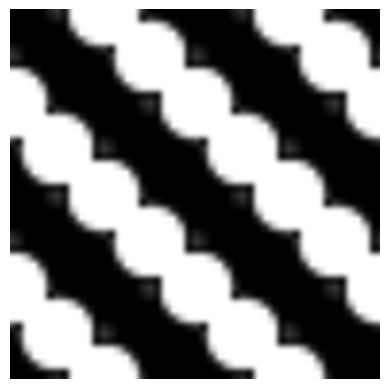

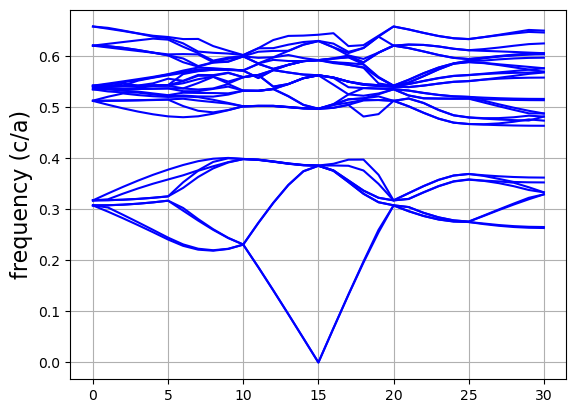

In [47]:
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=True, periods=2, resolution=64)
eps = ms.get_epsilon()
cube_converted_eps = md.convert(eps)
layer_slice = 30
plt.imshow(cube_converted_eps[:,:, layer_slice], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue')
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()

plt.show()

These don't agree, so let's look at the 3D models and see if we can find the problem.

In [8]:
import trimesh
import trimesh.voxel as tv

rhombmesh = tv.ops.matrix_to_marching_cubes(rhomb_converted_eps, threshold = 8)

cubemesh = tv.ops.matrix_to_marching_cubes(cube_converted_eps, threshold= 8)
xshift = 10
yshift = 0
zshift = 0
translate = np.array(([1,0,0,xshift], [0,1,0,yshift], [0,0,1,zshift], [0,0,0,1]))
scene = trimesh.scene.Scene(cubemesh)
# scene.add_geometry(cubemesh, transform=translate)
scene.show(viewer='gl')



SceneViewer(width=1800, height=1350)

In [9]:
scene = trimesh.scene.Scene(rhombmesh)
# scene.add_geometry(cubemesh, transform=translate)
scene.show(viewer='gl')

SceneViewer(width=1800, height=1350)